In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import scipy.stats as stats
from toolz.curried import *

import gc_model as gc
import hic_analysis as hic
import visualize

In [331]:
M = 2
weights_params = (M**2 + M) // 2

lambdas = np.load(f'./output/lambda_probabilities_{M}states.npy')
orig_weights = np.load(f'./output/model_state_weights_{M}states.npy')
weights = gc.normalize(gc.triangle_to_symmetric(M, np.random.uniform(size=weights_params)))
weights_diag = gc.normalize(np.diag(np.random.uniform(size=M)))
alpha = np.load(f'./output/model_distance_decay_power_value_{M}states.npy')

In [6]:
def create_mask(n, i):
    m = np.zeros(n)
    m[i] = 1
    return m
random_lambdas = np.array([ create_mask(M, i) for i in np.random.randint(0, M, size=10) ])

In [21]:
def fit_bulk(weights, lambdas, alpha, count, number_of_states=M, **kwargs):
    mat = gc.generate_interactions_matrix(lambdas, weights, alpha)
    return [gc.fit(mat, number_of_states=number_of_states, **kwargs) for i in range(count)]

In [13]:
def sort_weights(weights):
    self_weights = np.diag(weights)
    M = self_weights.size
    weights_order = np.argsort(self_weights)
    sorted_weights = np.empty_like(weights)
    for i in range(M):
        w_i = weights_order[i]
        for j in range(M):
            w_j = weights_order[j]
            sorted_weights[i, j] = weights[w_i, w_j]
    return sorted_weights, weights_order

In [16]:
fit_bigw_bulk = fit_bulk(weights_diag, random_lambdas, alpha, count=50, number_of_states=50)

In [32]:
def mass_plot(fit_bulk):
    count = len(fit_bulk)
    plt.figure(figsize=(4*1.5, 3*1.5*count))
    for i, b in enumerate(fit_bulk):
        plt.subplot(count, 1, i+1)
        plt.imshow(sort_weights(b[1])[0])

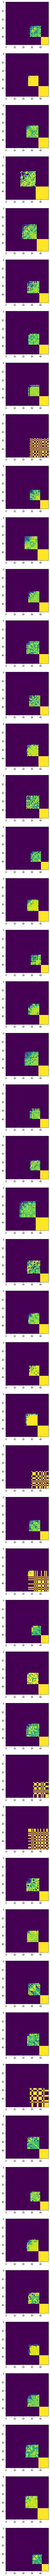

In [35]:
mass_plot(fit_bigw_bulk)

In [523]:
fit_bigw_diag_bulk = fit_bulk(weights_diag, random_lambdas, alpha, count=50, number_of_states=50, weights_shape='diag')

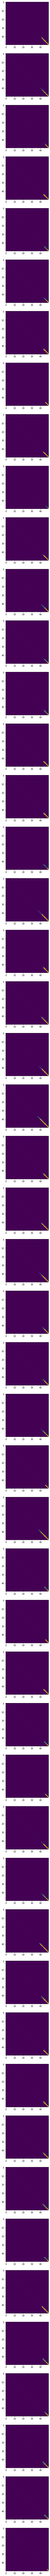

In [524]:
mass_plot(fit_bigw_diag_bulk)

In [525]:
fit_bigw_eye_bulk = fit_bulk(weights_diag, random_lambdas, alpha, count=50, number_of_states=50, weights_shape='eye')

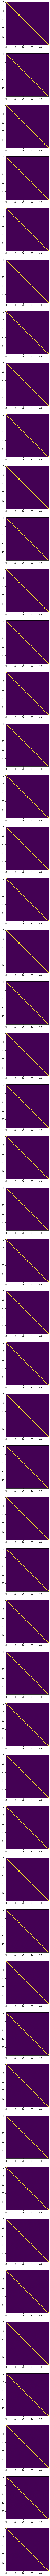

In [526]:
mass_plot(fit_bigw_eye_bulk)

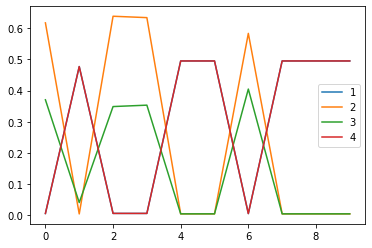

In [64]:
plt.plot(fit_bigw_diag_bulk[3][0])
plt.legend(['1','2','3','4'])

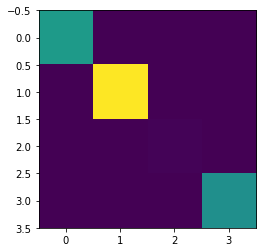

In [58]:
plt.imshow(fit_bigw_diag_bulk[3][1])

In [62]:
fit_bigw_diag_bulk[3][1]

array([[0.2646722 , 0.        , 0.        , 0.        ],
       [0.        , 0.48696212, 0.        , 0.        ],
       [0.        , 0.        , 0.00491881, 0.        ],
       [0.        , 0.        , 0.        , 0.24344687]])

In [438]:
@curry
def likelihood(interactions_mat, fit_mat):
    clean_interactions_mat = gc.preprocess(interactions_mat)
    unique_interactions = gc.get_unique_interactions(clean_interactions_mat)
    clean_fit_mat = gc.preprocess(fit_mat)
    unique_fit_interactions = gc.get_unique_interactions(clean_fit_mat)

    return np.nansum(unique_interactions * hic.safe_log(unique_fit_interactions))

@curry
def likelihood_ratio(interactions_mat, fit_mat):
    return np.exp(likelihood(interactions_mat, fit_mat) - likelihood(interactions_mat, interactions_mat))

In [451]:
likelihood_rand = compose(likelihood(gc.generate_interactions_matrix(random_lambdas, weights_diag, alpha)),
                         gc.generate_interactions_matrix)
lr_rand = compose(likelihood_ratio(gc.generate_interactions_matrix(random_lambdas, weights_diag, alpha)),
                          gc.generate_interactions_matrix)

In [452]:
lr_rand(*fit_bigw_diag_bulk[3]), likelihood_rand(*fit_bigw_diag_bulk[3])

(0.9758917172675641, -2.866958103197041)

In [132]:
def merge_states(fit, merged):
    bins = fit[0].shape[0]
    states = len(merged)
    lambdas = np.empty((bins, states))
    weights = np.zeros((states, states))
    for i, m in enumerate(merged):
        if type(m) is int:
            weights[i, i] = fit[1][m, m]
            lambdas[:, i] = fit[0][:, m]
        elif type(m) is list:
            weights_indices = tuple(zip(*itertools.combinations_with_replacement(m, 2)))
            weights[i, i] = fit[1][weights_indices].sum()
            lambdas[:, i] = fit[0][:, m].sum(axis=1)
        else:
            raise ValueError()
    
    return lambdas, weights, fit[2]

In [565]:
merged = merge_states(fit_bigw_diag_bulk[3], [0,1,2,3])
lr_rand(*merged)

0.9761653143149754

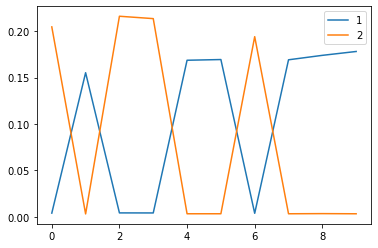

In [564]:
plt.plot(merge_states(fit_bigw_diag_bulk[3], [[0,3],[1,2]])[0])
plt.legend(['1','2','3','4'])

In [138]:
fit_bigw_diag_bulk[3][1]

array([[0.2646722 , 0.        , 0.        , 0.        ],
       [0.        , 0.48696212, 0.        , 0.        ],
       [0.        , 0.        , 0.00491881, 0.        ],
       [0.        , 0.        , 0.        , 0.24344687]])

In [186]:
fit_2states = fit_bulk(weights_diag, random_lambdas, alpha, count=1, number_of_states=2, weights_shape='diag')[0]

In [453]:
lr_rand(partial_round(fit_2states[0], []), fit_2states[1], fit_2states[2])

0.9751809617428306

In [425]:
def partial_round(vec, to_round):
    if len(to_round) == 0:
        return vec
    states = vec.shape[1]
    t = np.copy(vec)
    t[to_round] = [create_mask(states, m) for m in np.argmax(vec[to_round, :], axis=1)]
    
    return t

def round_lambdas(fit, to_round):
    return partial_round(fit[0], to_round), fit[1], fit[2]

In [427]:
lr_rand(*round_lambdas(fit_bigw_diag_bulk[3], range(10)))

0.9964260647575778

In [317]:
round_lambdas(fit_bigw_diag_bulk[3], range(2))

(array([[0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [0.00644723, 0.638276  , 0.34882954, 0.00644723],
        [0.00640245, 0.6338424 , 0.3533527 , 0.00640245],
        [0.495     , 0.005     , 0.005     , 0.495     ],
        [0.495     , 0.005     , 0.005     , 0.495     ],
        [0.0058922 , 0.58332772, 0.40488788, 0.0058922 ],
        [0.495     , 0.005     , 0.005     , 0.495     ],
        [0.495     , 0.005     , 0.005     , 0.495     ],
        [0.495     , 0.005     , 0.005     , 0.495     ]]),
 array([[0.2646722 , 0.        , 0.        , 0.        ],
        [0.        , 0.48696212, 0.        , 0.        ],
        [0.        , 0.        , 0.00491881, 0.        ],
        [0.        , 0.        , 0.        , 0.24344687]]),
 -0.892795877655569)

In [312]:
np.array([create_mask(4, m) for m in np.argmax(fit_bigw_diag_bulk[3][0], axis=1)])

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [439]:
input_data = np.load('Rao2015_chr20_20000.npy')
likelihood_input = compose(likelihood(input_data), gc.generate_interactions_matrix)
lr_input = compose(likelihood_ratio(input_data), gc.generate_interactions_matrix)

In [448]:
lr_input(partial_round(lambdas, range(10)), orig_weights, alpha)

0.8672463687096282

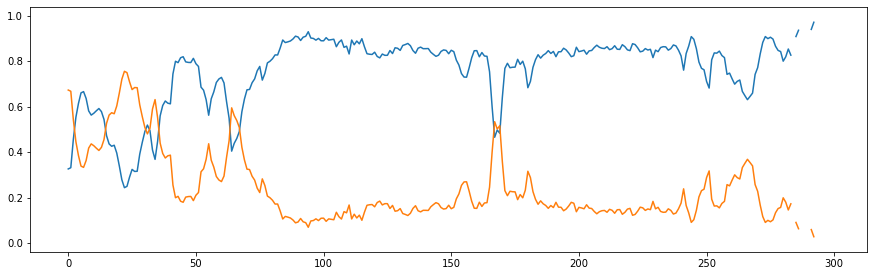

In [469]:
plt.figure(figsize=(15, 4.5))
plt.plot(lambdas[1000:1300])

In [472]:
lambdas3 = np.load(f'./output/lambda_probabilities_3states.npy')
orig_weights3 = np.load(f'./output/model_state_weights_3states.npy')
alpha3 = np.load(f'./output/model_distance_decay_power_value_3states.npy')

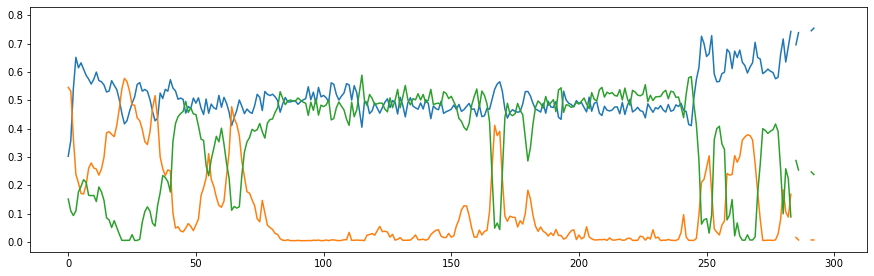

In [468]:
plt.figure(figsize=(15, 4.5))
plt.plot(lambdas3[1000:1300])

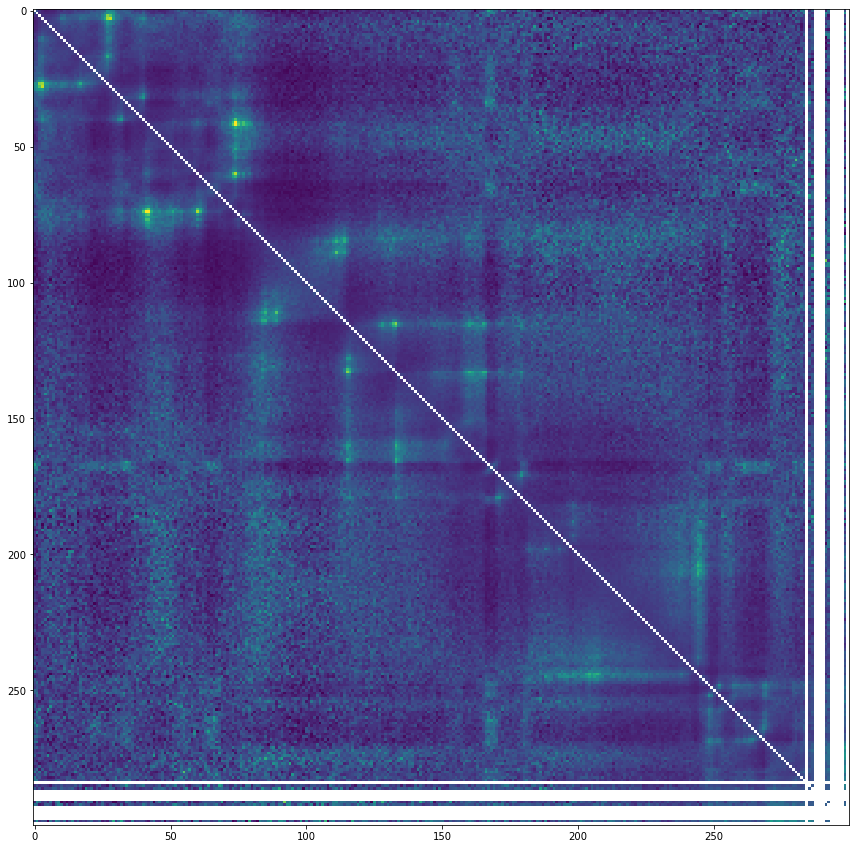

In [481]:
plt.figure(figsize=(15, 15))
plt.imshow(hic.normalize_distance(input_data)[1000:1300,:][:,1000:1300])

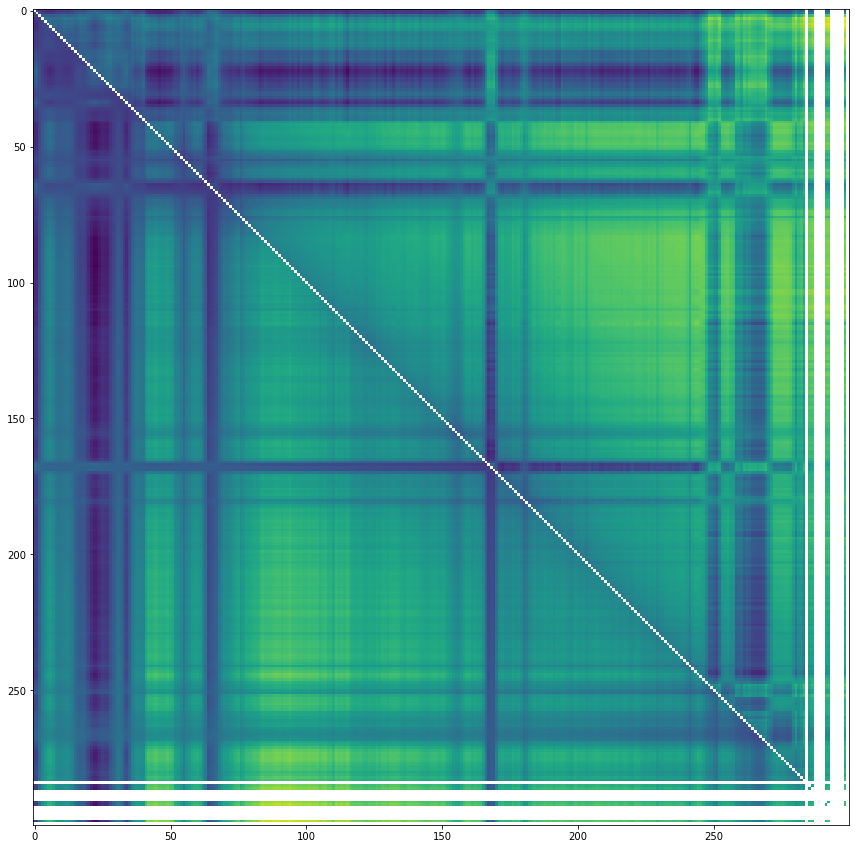

In [477]:
mat_slice2 = hic.normalize_distance(gc.generate_interactions_matrix(lambdas, orig_weights, alpha))[1000:1300,:][:,1000:1300]
mat_slice3 = hic.normalize_distance(gc.generate_interactions_matrix(lambdas3, orig_weights3, alpha3))[1000:1300,:][:,1000:1300]
plt.figure(figsize=(15, 15))
plt.imshow(hic.merge_by_diagonal(mat_slice2, mat_slice3))

In [584]:
lr_input(lambdas, orig_weights, alpha), lr_input(lambdas3, orig_weights3, alpha3)

(0.8682528676203609, 0.8775856364391866)

In [509]:
fit_bigw_eye2 = fit_bulk(weights_diag, random_lambdas, alpha, count=1, number_of_states=2, weights_shape='eye')[0]
fit_bigw_eye3 = fit_bulk(weights_diag, random_lambdas, alpha, count=1, number_of_states=3, weights_shape='eye')[0]

In [517]:
lr_rand(*round_lambdas(fit_bigw_eye2, range(0)))

0.955813377738584

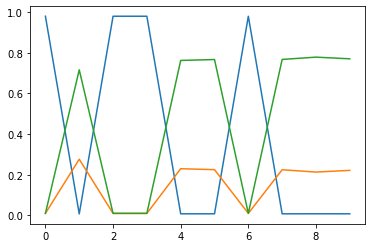

In [505]:
plt.plot(fit_bigw_eye_bulk[0])

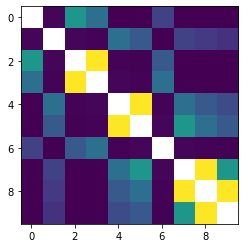

In [514]:
plt.imshow(gc.generate_interactions_matrix(*fit_bigw_eye2))

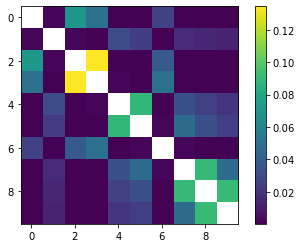

In [516]:
plt.imshow(gc.generate_interactions_matrix(*fit_bigw_eye3))
plt.colorbar()

In [551]:
compose(list,map(len), map(list), map(filter(lambda x: x>0.022)), map(partial(np.max, axis=0)), pluck(0))(fit_bigw_eye_bulk)

[41,
 38,
 46,
 38,
 42,
 41,
 39,
 41,
 39,
 43,
 39,
 41,
 36,
 39,
 41,
 36,
 49,
 39,
 40,
 41,
 38,
 38,
 40,
 39,
 36,
 41,
 36,
 41,
 43,
 39,
 34,
 39,
 36,
 41,
 36,
 36,
 36,
 36,
 35,
 41,
 39,
 40,
 38,
 39,
 36,
 45,
 39,
 36,
 44,
 39]

In [568]:
x = gc.get_unique_interactions(gc.generate_interactions_matrix(random_lambdas, weights_diag, alpha))
np.nansum(x * hic.safe_log(x))

-2.842554459050521

In [575]:
lr_rand(np.round(fit_bigw_eye2[0], decimals=1), fit_bigw_eye2[1], fit_bigw_eye2[2])

0.9779500964807071

In [581]:
lr_rand(np.round(fit_bigw_eye3[0], decimals=1), fit_bigw_eye3[1], fit_bigw_eye3[2])

0.9995157756893708

In [585]:
fit_bigw_eye3[1]

array([[0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333]])

In [785]:
import pickle
fit_input_big = pickle.load(open('fit_input_big.pickle', 'rb'))

In [645]:
pluck_lambdas = pluck(0)
pluck_weights = pluck(1)
pluck_alpha = pluck(2)
@curry
def draw_rows(func, objs, titles=None):
    n = len(objs)
    fig = plt.figure(figsize=(4*1.5, 3*1.5*n))
    for i, obj in enumerate(objs):
        ax = plt.subplot(n, 1, i+1)
        getattr(ax, func)(obj)
        if titles is None:
            title = f'Plot {i+1}'
        else:
            title = next(titles)   
        ax.set_title(title)    

plot_rows = draw_rows('plot')
imshow_rows = draw_rows('imshow')

def Ms(i=10):
    while True:
        yield f'M={i}'
        i+=10

In [651]:
def switch_states(m, switch_list):
    n = m.shape[0]
    order = np.arange(n)
    for s1, s2 in switch_list:
        order[s1], order[s2] = order[s2], order[s1]
    return m[order, :][:, order]

In [705]:
unzip = lambda zipped: zip(*zipped)

In [782]:
def plot_all(fit):
    sorted_weights, weights_order = compose(unzip, map(sort_weights), pluck_weights)(fit)
    order_by_weights = compose(map(lambda a: a[1][a[0]]), partial(zip, weights_order))
    lambdas_colsum = compose(order_by_weights, map(partial(np.nansum, axis=0)), pluck_lambdas)(fit)
    lambdas_colmax = compose(order_by_weights, map(partial(np.nanmax, axis=0)), pluck_lambdas)(fit)

    n = len(weights_order)
    titles = Ms(10)
    plt.figure(figsize=(4*1.5 * 3, 3*1.5 * n))
    for i, w, s, m in zip(itertools.count(1), sorted_weights, lambdas_colsum, lambdas_colmax):
        ax = plt.subplot(n, 3, 3*(i-1) + 1)
        plt.imshow(w)
        if ax.is_first_row():
            plt.title("Weights")
        plt.ylabel(next(titles))
        plt.colorbar()
        ax = plt.subplot(n, 3, 3*(i-1) + 2)
        plt.plot(s)
        plt.axvline(0, c='k', linestyle='--')
        if ax.is_first_row():
            plt.title("Lambdas sum")
        ax = plt.subplot(n, 3, 3*(i-1) + 3)
        plt.plot(m)
        plt.axvline(0, c='k', linestyle='--')
        if ax.is_first_row():
            plt.title("Lambdas max")
    plt.tight_layout()

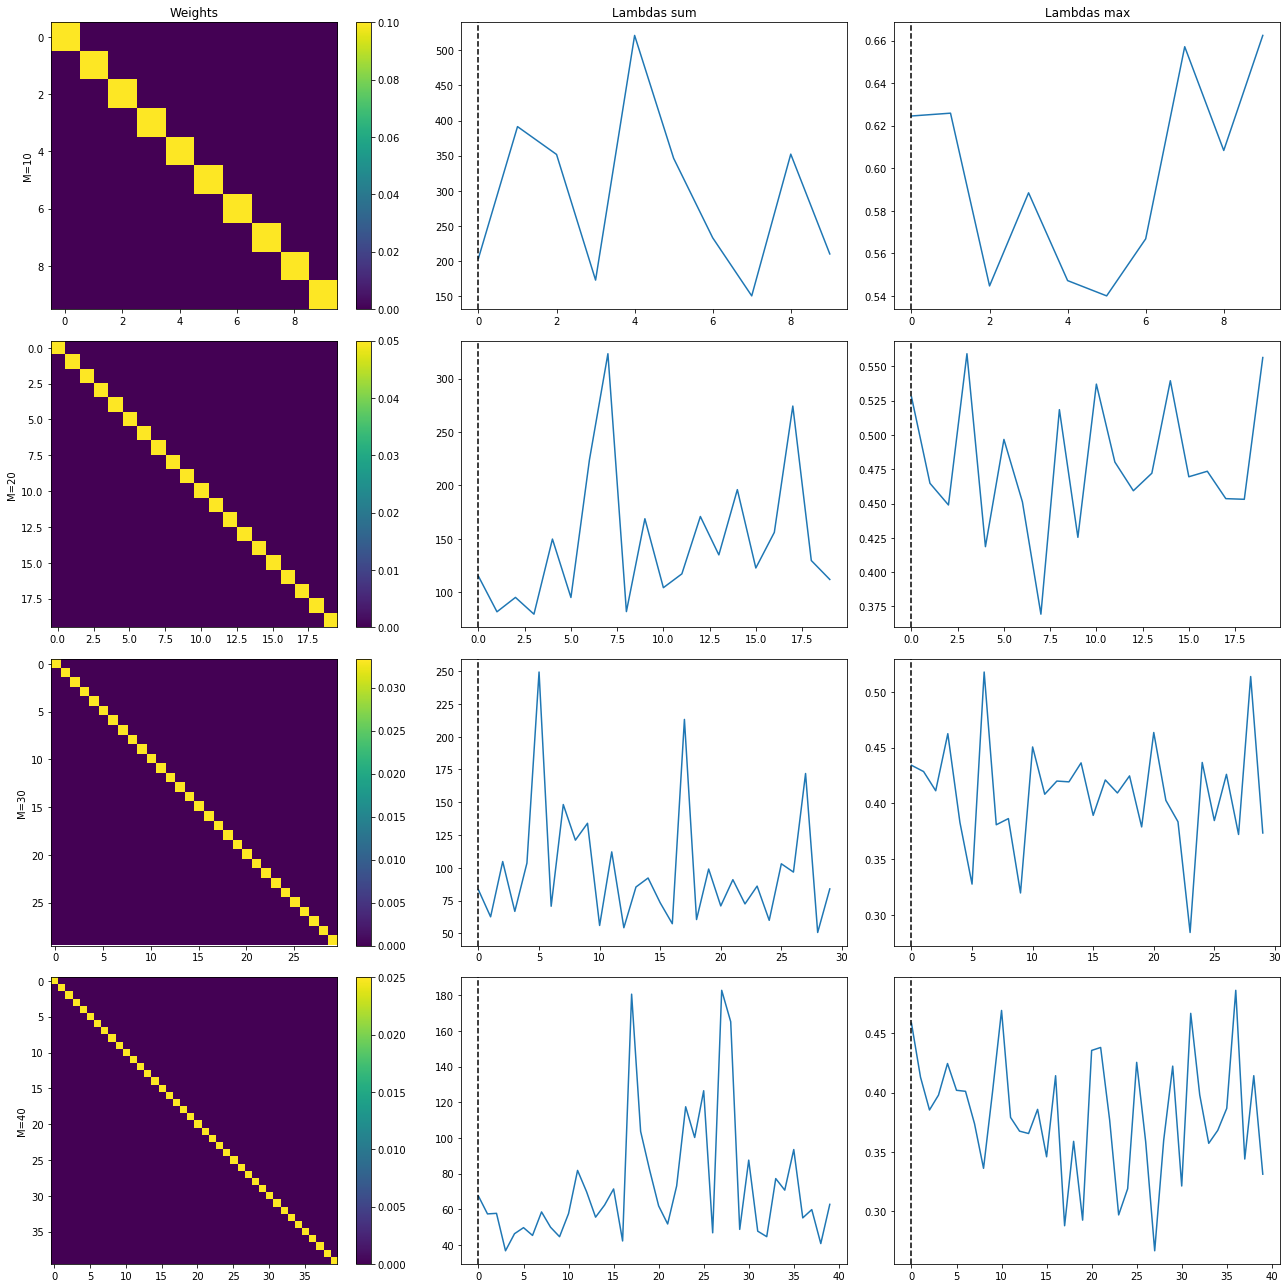

In [786]:
plot_all(fit_input_big['eye'])

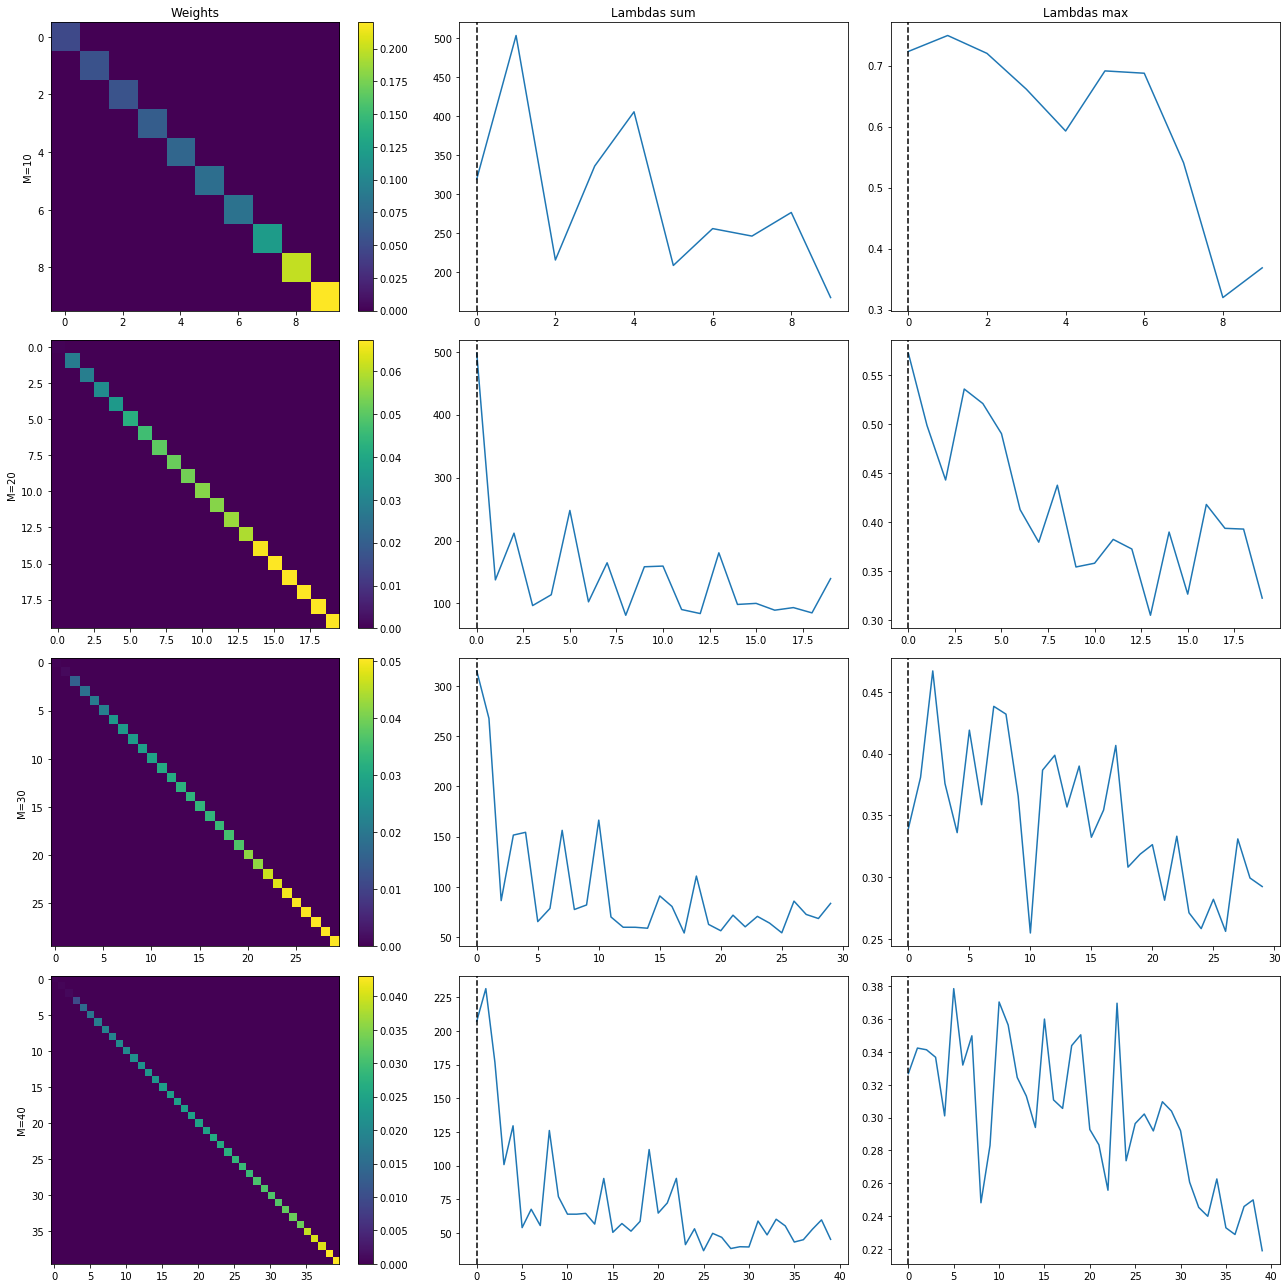

In [787]:
plot_all(fit_input_big['diag'])

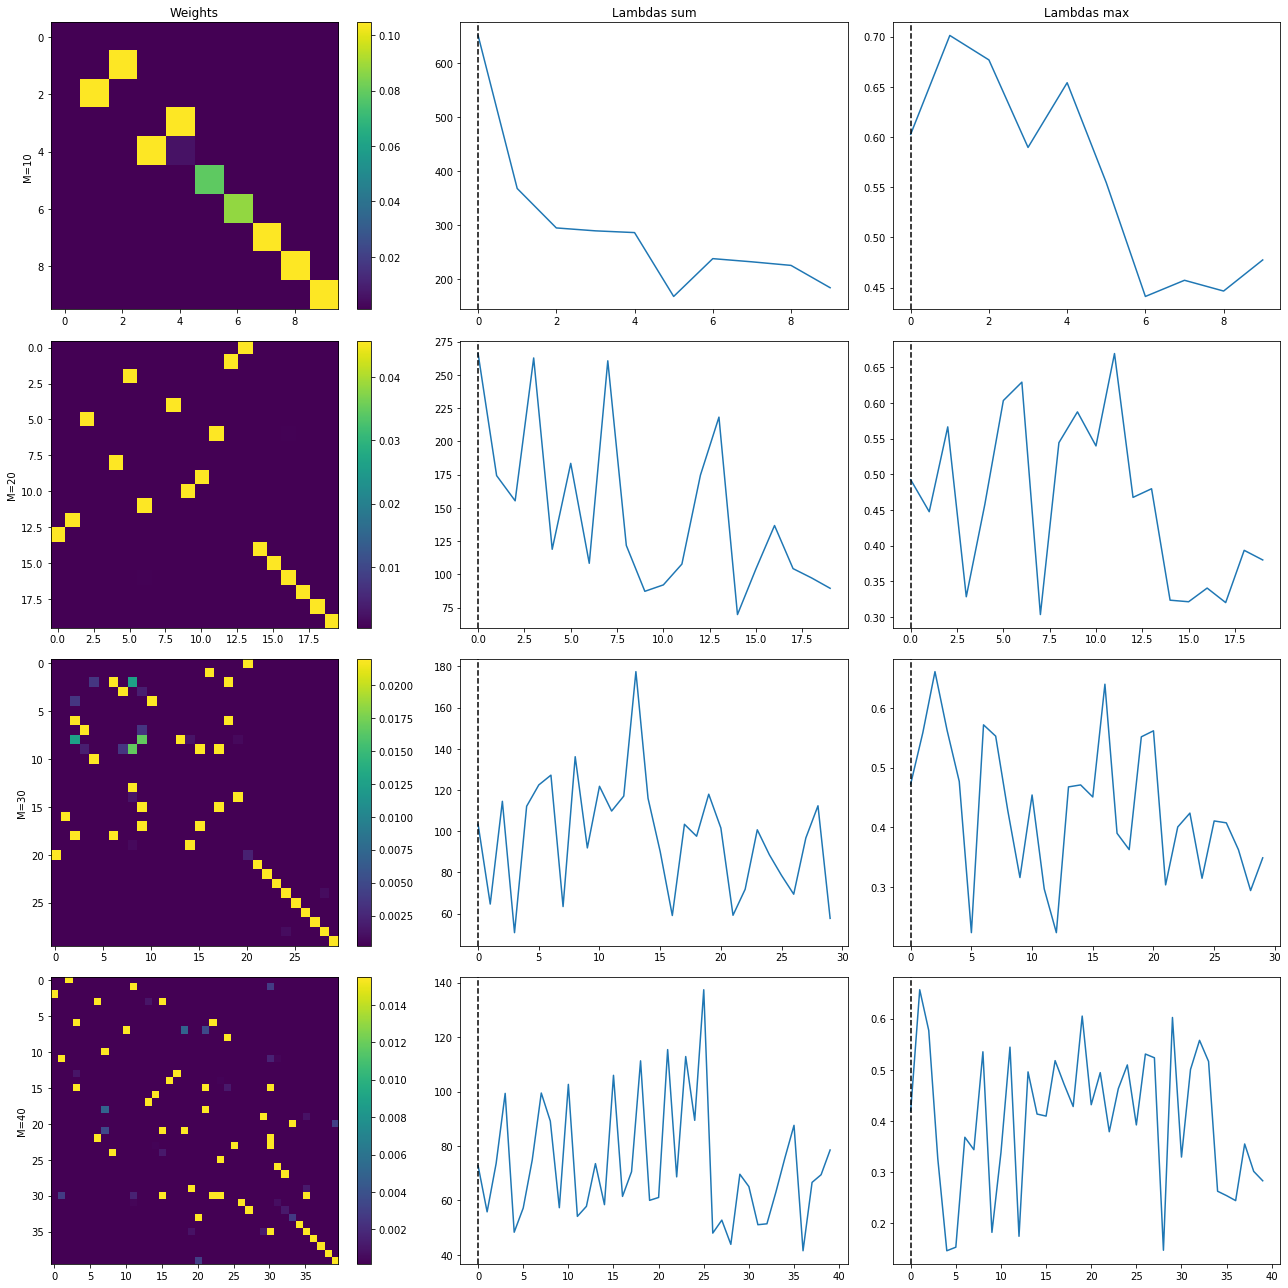

In [788]:
plot_all(fit_input_big['symmetric'])

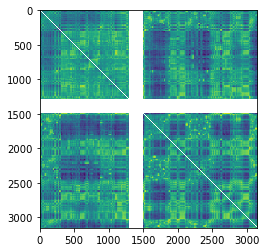

In [761]:
plt.imshow(hic.safe_log(hic.normalize_distance(gc.generate_interactions_matrix(*fit_input_big['eye'][2]))))

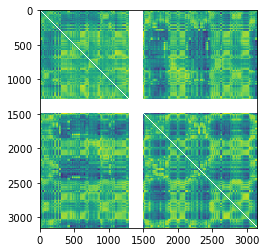

In [755]:
plt.imshow(hic.safe_log(hic.normalize_distance(gc.generate_interactions_matrix(*fit_input_big['eye'][0]))))

In [763]:
unpack_args = lambda f: lambda a: f(*a)

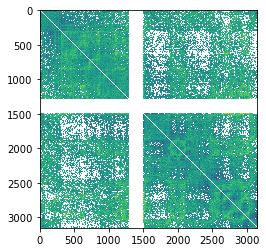

In [746]:
plt.imshow(hic.safe_log(hic.normalize_distance(hic.preprocess(input_data))))

In [789]:
compose(list, map(unpack_args(lr_input)))(fit_input_big['eye'])

[0.9118351745924265,
 0.9223026310070123,
 0.9267462004772676,
 0.9302766642293285]

In [790]:
compose(list, map(unpack_args(lr_input)))(fit_input_big['diag'])

[0.9126707301489091,
 0.9230474205432866,
 0.9279070134952536,
 0.9307289921494752]

In [791]:
compose(list, map(unpack_args(lr_input)))(fit_input_big['symmetric'])

[0.9133921408682131,
 0.9252836788950344,
 0.9297621509577061,
 0.9328610663455454]

497.67760606282087


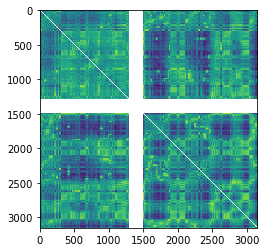

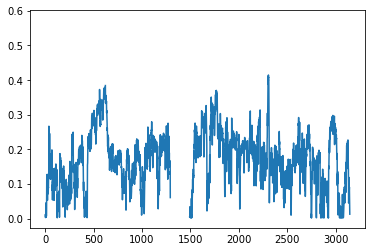

In [784]:
def blah(fit):
    sorted_weights, weights_order = compose(unzip, map(sort_weights), pluck_weights)(fit)
    order_by_weights = compose(map(lambda a: a[1][:, a[0]]), partial(zip, weights_order))
    lambdas_colsum = compose(order_by_weights, map(partial(np.nansum, axis=0)), pluck_lambdas)(fit)
    lambdas_colmax = compose(order_by_weights, map(partial(np.nanmax, axis=0)), pluck_lambdas)(fit)
    
    plt.figure()
    plt.imshow(hic.safe_log(hic.normalize_distance(gc.generate_interactions_matrix(*fit[1]))))
    plt.figure()
    plt.plot(list(order_by_weights(pluck_lambdas(fit)))[1][:, 0])
    print(np.nansum(list(order_by_weights(pluck_lambdas(fit)))[1][:, 0]))
blah(fit_input_big['diag'])

In [777]:
fit_input_big['diag'][1][0].shape

(3152, 20)

In [822]:
a = np.nansum(hic.balance(input_data), axis=0)
a[a!=0]

array([2931.79537006, 2931.7709588 , 2931.73190157, ..., 2931.4300578 ,
       2931.42504375, 2931.50171606])

In [821]:
np.any(np.abs(np.nanmean(input_data, axis=0) - 1) > 0.1 )

/Users/hkariti/anaconda3/envs/kaplanlab/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/hkariti/anaconda3/envs/kaplanlab/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


True

In [804]:
nn2 = ~np.isnan((input_data)).all(1)

In [825]:
M

2

In [833]:
random_lambdas_big = np.array([ create_mask(M, i) for i in np.random.randint(0, M, size=1000) ])
p_sym = gc.generate_interactions_matrix(random_lambdas_big, weights_diag, alpha)
p = p_sym[np.tril_indices_from(p_sym)]

In [889]:
generated_p = np.zeros_like(p)
samples = np.random.choice(p.size, p=np.nan_to_num(p), size=100000)

In [890]:
for s in samples:
    generated_p[s] += 1

In [891]:
generated_p[np.isnan(p)] = np.nan

In [892]:
P = np.zeros_like(p_sym)
P[np.tril_indices_from(p_sym)] = generated_p / np.nansum(generated_p)
P = P + P.T

In [893]:
sampled_fits = [ gc.fit(P, number_of_states=30) for i in range(10) ]

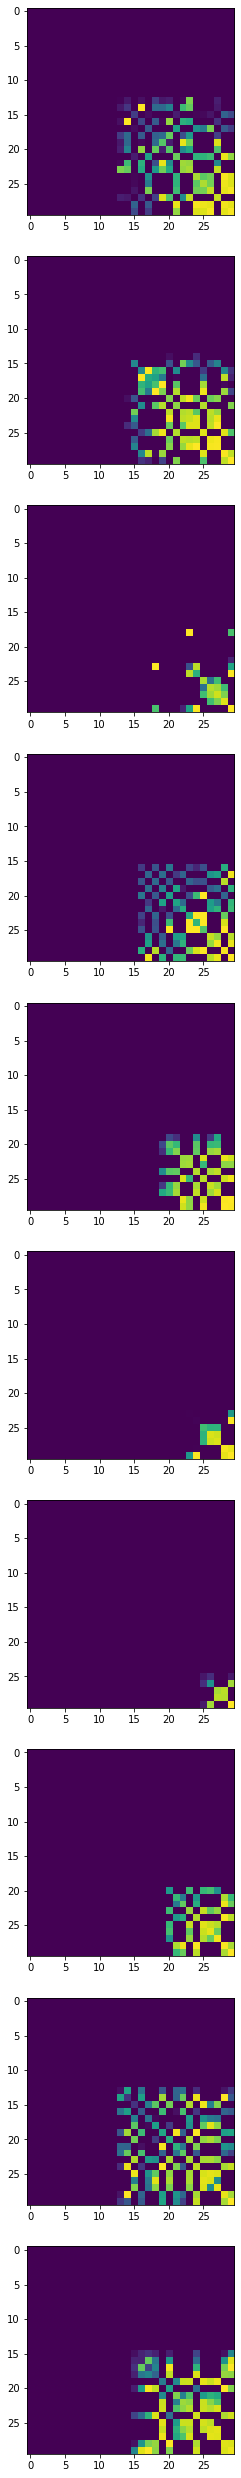

In [888]:
mass_plot(sampled_fits)

In [877]:
noisy_p = p + np.random.normal(scale=np.nanstd(p)/10, size=p.size)

In [879]:
P = np.zeros_like(p_sym)
P[np.tril_indices_from(p_sym)] = noisy_p / np.nansum(noisy_p)
P = P + P.T

In [884]:
noisy_fits = [gc.fit(P, number_of_states=30) for i in range(10) ]

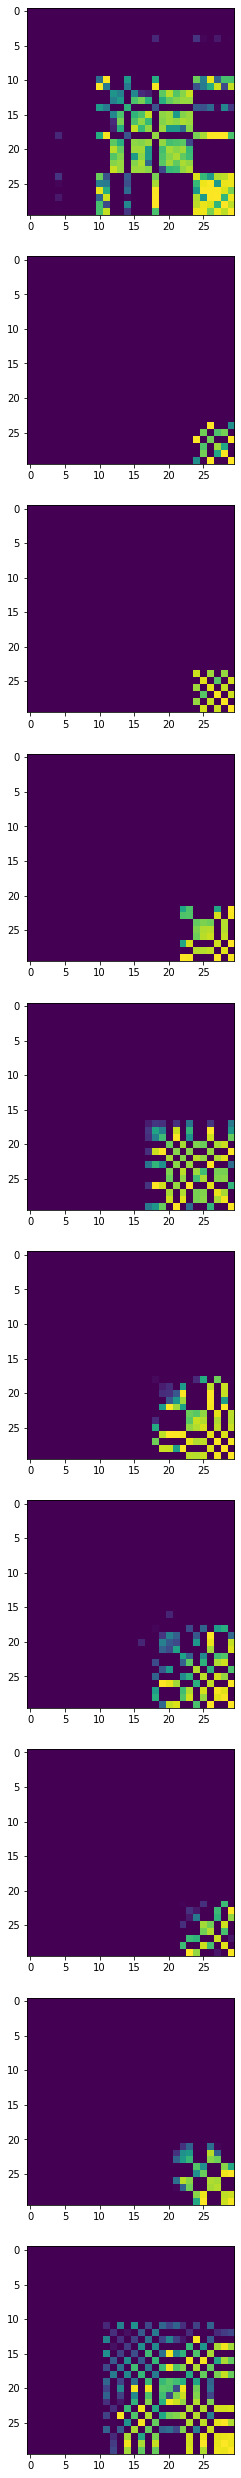

In [887]:
mass_plot(noisy_fits)

In [878]:
np.isnan(noisy_p).all()

False

In [ ]:
nois